# PREDICTING CUMMULATIVE TEMPERATURE USING ARIMA
# (TIME SERIES)

## Table of contents
1. [Description and Objective](#Objective)<br>
2. [Data Loading](#DataLoading)<br>
3. [Decomposition](#Decomposition)<br>
4. [Stationarity Check](#StationarityCheck)<br>
    4.1. [Rolling Statistics Methodology](#RollingStatisticsMethodology)<br>
    4.2. [ADF(Augmented Dickey-Fuller)Test](#ADF)<br>
5. [Data Transformation to achieve Stationarity](#DataTransformationtoachieveStationarity)<br>
    5.1. [Log Scale Transformation](#LogScaleTransformation)<br>
    5.2. [Log Scale - Moving Average Transformation](#LogScaleMovingAverageTransformation)<br>
    5.3. [Exponential Decay Transformation](#ExponentialDecayTransformation)<br>
    5.4. [Time Shift Transformation](#TimeShiftTransformation)<br>
6. [Plotting ACF & PACF](#PlottingACFPACF)
7. [Building Models](#BuildingModels)<br>
    7.1. [AR Model](#ARModel)<br>
    7.2. [ARMA Model](#ARMAModel)<br>
    7.3. [ARIMA Model](#ARIMAModel)<br>
8. [Prediction for next 10 years](#Predictionfor10)

<a id=Objective></a>
## SECTION 1:Description and Objective

Data Description:
This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
The units are in degrees Celsius and there are 3650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

Objective:
To predict the month-wise cumulative temperature using Time series Models


In [1]:
import warnings                                  
warnings.filterwarnings('ignore')                # `do-not-disturb` mode

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
%matplotlib inline

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.stattools import adfuller

                 # some useful functions
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [2]:
class Data:
  
    def __init__(self):
        self.data=None
        self.log_transformed_data=None
        self.logMovingAvg_transformed_data=None
        self.exponentialDecay_transformed_data=None
        self.timeShift_transformed_data=None

    def load_data(self,filename,separator=' '):
        try:
            if(separator==','):
                self.data=pd.read_csv(filename,sep=',',header=0,index_col=['Date'], parse_dates=['Date'])
            else:
                raise ValueError(separator+'separator is not supported by this system for now.')
        except ValueError as e:
            print(e)
        
    def overview_data(self):
        print(self.data.head(20))
    
    def rename_columns(self,names):
        self.data.columns=names
        
    def set_time_freq(self,time_period):
        self.data=self.data.resample(time_period).sum()
        return self.data
    
    def data_decomposition(self):
        rcParams['figure.figsize']  =  10, 5
        decomposed_dataset  =  seasonal_decompose(self.data)         
        figure  =  decomposed_dataset.plot()
        plt.show()
        
    def get_data(self):
        return self.data
    
    def log_transformation(self,data):
        self.data=data
        self.log_transformed_data  =  np.log(self.data)
        return self.log_transformed_data
    
    def log_movingAverage_transformation(self,data):
        self.log_transformed_data=self.log_transformation(data)
        movingAverage  =  self.log_transformed_data.rolling(window = 12).mean()
        self.logMovingAvg_transformed_data  =  self.log_transformed_data - movingAverage
        return self.logMovingAvg_transformed_data
    
    def exponential_decay_transformation(self,data):
        self.log_transformed_data=self.log_transformation(data)
        self.exponentialDecay_transformed_data  =  self.log_transformed_data.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
        return self.exponentialDecay_transformed_data
    
    def timeshift_transformation(self,data):
        self.log_transformed_data=self.log_transformation(data)
        self.timeShift_transformed_data  =  self.log_transformed_data - self.log_transformed_data.shift()
        return self.timeShift_transformed_data
        
    def data_split(self,data):
        self.data=data
        train,test=train_test_split(self.data["Temp"],test_size=0.2)
        return train,test
        


In [3]:
class TimeSeries:
    def __init__(self,data):
        self.data=data
    
    # Creating a helper function to plot the Moving Average.
    def get_data(self):
        return self.data
    
    def plotMovingAverage(self,data, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
        self.data=data
        rolling_mean = self.data.rolling(window=window).mean()

        plt.figure(figsize=(15,5))
        plt.title("Moving average\n window size = {}".format(window))
        plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
        if plot_intervals:
            mae = mean_absolute_error(self.data[window:], rolling_mean[window:])
            deviation = np.std(self.data[window:] - rolling_mean[window:])
            lower_bound = rolling_mean - (mae + scale * deviation)
            upper_bound = rolling_mean + (mae + scale * deviation)
            plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
            plt.plot(lower_bound, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=self.data.index, columns=self.data.columns)
            anomalies[self.data<lower_bound] = self.data[self.data<lower_bound]
            anomalies[self.data>upper_bound] = self.data[self.data>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
        
        plt.plot(self.data[window:], label="Actual values")
        plt.legend(loc="upper left")
        plt.grid(True)
        
    
    def rolling_means(self,data,window_value):
        self.data=data
        rolmean  =  self.data.rolling(window = window_value).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
        rolstd  =  self.data.rolling(window = window_value).std()

        #Plot rolling statistics

        rcParams['figure.figsize']  =  10, 5 

        orig  =  plt.plot(self.data, color = 'blue', label = 'Original')
        mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
        std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
        plt.legend(loc = 'best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block = False)
    
    def adf_test(self,data):
        self.data=data
        dftest  =  adfuller(self.data['Temp'], autolag = 'AIC')

        dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key]  =  value

        print('Results of Dickey Fuller Test:')    
        print(dfoutput)
    
    def plotting_acf_pacf(self,data):
        #ACF & PACF plots
        lag_acf  =  acf(data, nlags = 20)
        lag_pacf  =  pacf(data, nlags = 20, method = 'ols')
        rcParams['figure.figsize']  =  10, 5
        #Plot ACF:
        plt.subplot(121)
        plt.plot(lag_acf)
        plt.axhline(y = 0, linestyle = '--', color = 'gray')
        plt.axhline(y = -1.96/np.sqrt(len(data)), linestyle = '--', color = 'gray')
        plt.axhline(y = 1.96/np.sqrt(len(data)), linestyle = '--', color = 'gray')
        plt.xticks(np.arange(0,22,2))
        plt.title('Autocorrelation Function')            

        #Plot PACF
        plt.subplot(122)
        plt.plot(lag_pacf)
        plt.axhline(y = 0, linestyle = '--', color = 'gray')
        plt.axhline(y = -1.96/np.sqrt(len(data)), linestyle = '--', color = 'gray')
        plt.axhline(y = 1.96/np.sqrt(len(data)), linestyle = '--', color = 'gray')
        plt.xticks(np.arange(0,22,2))
        plt.title('Partial Autocorrelation Function')

        plt.tight_layout()            
    
    

<a id=DataLoading></a>

## SECTION 2:Data Loading

In [4]:
data = Data()

In [5]:
data.load_data("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", ",")

In [6]:
data.overview_data()

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
1981-01-06  15.8
1981-01-07  15.8
1981-01-08  17.4
1981-01-09  21.8
1981-01-10  20.0
1981-01-11  16.2
1981-01-12  13.3
1981-01-13  16.7
1981-01-14  21.5
1981-01-15  25.0
1981-01-16  20.7
1981-01-17  20.6
1981-01-18  24.8
1981-01-19  17.7
1981-01-20  15.5


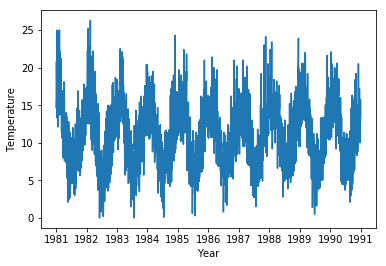

In [7]:
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.plot(data.get_data())

In [8]:
data.set_time_freq('1M')

,Temp
Date,
1981-01-31,549.1
1981-02-28,495.0
1981-03-31,418.5
1981-04-30,370.7
1981-05-31,294.2
1981-06-30,219.2
1981-07-31,234.9
1981-08-31,224.4
1981-09-30,304.3


<a id=Decomposition></a>

## SECTION 3:Decomposition

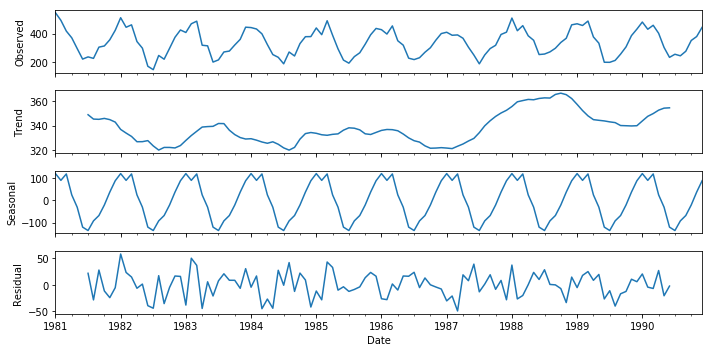

In [9]:
data.data_decomposition()

In [10]:
timeSeries=TimeSeries(data.get_data())

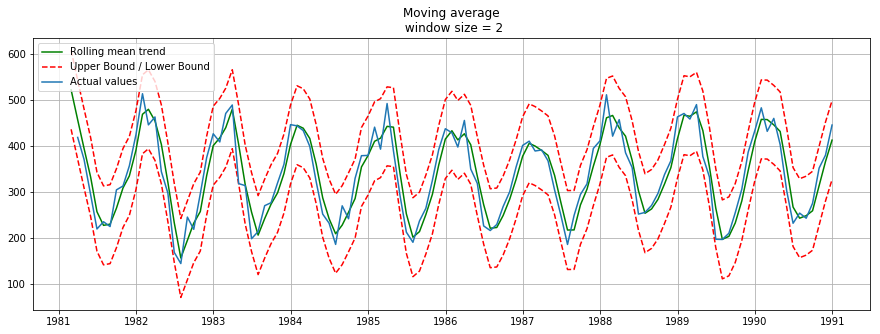

In [11]:
timeSeries.plotMovingAverage(timeSeries.get_data(),2,plot_intervals=True,plot_anomalies=True)

<a id=StationarityCheck></a>

## SECTION 4:Stationarity Check

<a id=RollingStatisticsMethodology></a>
### SECTION 4.1:Rolling Statistics Methodology

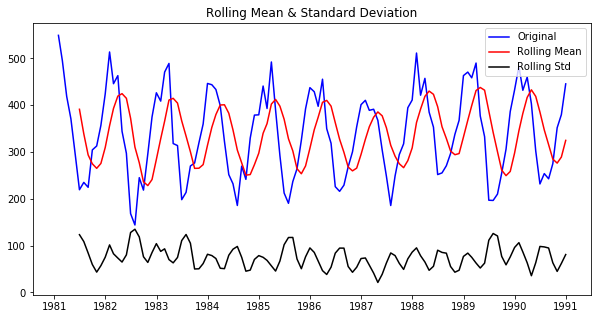

In [12]:
timeSeries.rolling_means(timeSeries.get_data(),6)

<a id=ADF></a>
### SECTION 4.2:ADF(Augmented Dickey-Fuller)Test

In [13]:
timeSeries.adf_test(timeSeries.get_data())

Results of Dickey Fuller Test:
Test Statistic                  -1.463365
p-value                          0.551550
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


<a id=DataTransformationtoachieveStationarity></a>
## SECTION 5:Data Transformation to achieve Stationarity
<a id=LogScaleTransformation></a>
### SECTION 5.1: Log Scale Transformation


In [14]:
log_transformed_data=data.log_transformation(data.get_data())

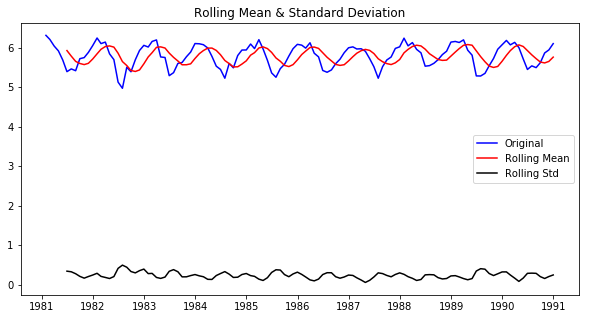

In [15]:
timeSeries.rolling_means(log_transformed_data,6)

In [16]:
timeSeries.adf_test(log_transformed_data)

Results of Dickey Fuller Test:
Test Statistic                  -2.270342
p-value                          0.181712
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


The plot shows that <b>Rolling Avg</b> and <b>Rolling Std Deviation</b> is <b>very flat</b>. The <b>ADF Test</b> shows <b>higher Test Statistic value(-2.27) than Critical Value (-3.49(1%),-2.88(5%),-2.58(10%)</b>. 


<b>Hence the result data is of Log Transformation not Stationary</b>

<a id=LogScaleMovingAverageTransformation></a>
### SECTION 5.2:Log Scale - Moving Average Transformation


In [17]:
log_MovingAverage_data=data.log_movingAverage_transformation(data.get_data())

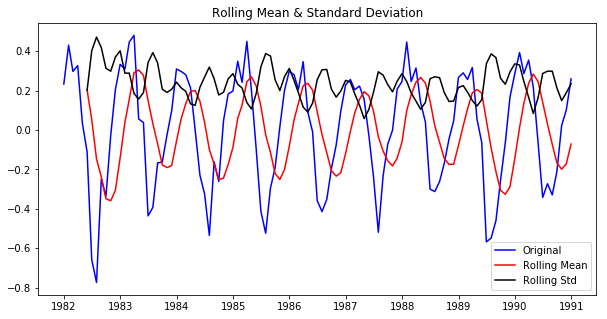

In [18]:
timeSeries.rolling_means(log_MovingAverage_data,6)

In [19]:
timeSeries.adf_test(log_MovingAverage_data.dropna())

Results of Dickey Fuller Test:
Test Statistic                 -3.988111
p-value                         0.001474
#Lags Used                     13.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


The plot shows that <b>Rolling Avg</b> and <b>Rolling Std Deviation</b> is <b>flat</b>. The <b>ADF Test</b> shows <b>low Test Statistic value(-3.988) than Critical Value (-3.5(1%),-2.89(5%),-2.58(10%)</b>. 


<b>Hence the result data is of Log Moving Average Transformation is Stationary and can be taken for Modelling.</b>

<a id=ExponentialDecayTransformation></a>
### SECTION 5.3:Exponential Decay Transformation

In [20]:
exponential_decay_data=data.exponential_decay_transformation(data.get_data())

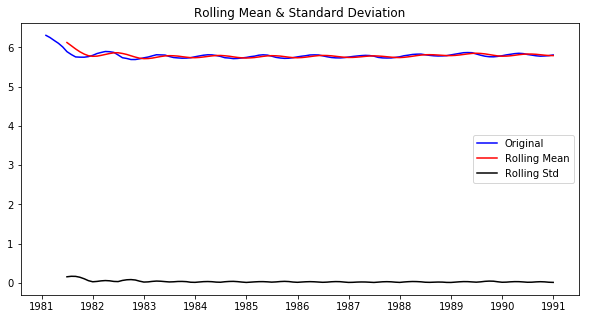

In [21]:
timeSeries.rolling_means(exponential_decay_data,6)

In [22]:
timeSeries.adf_test(exponential_decay_data)

Results of Dickey Fuller Test:
Test Statistic                  -0.792033
p-value                          0.821451
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


The plot shows that <b>Rolling Avg</b> and <b>Rolling Std Deviation</b> is <b>very flat</b>. Whereas the <b>ADF Test</b> shows <b>higher Test Statistic value(-0.79) than Critical Value (-3.49(1%),-2.88(5%),-2.58(10%)</b>. 


<b>Hence the result data is of Exponential Decay Transformation not Stationary</b>

<a id=TimeShiftTransformation></a>
### SECTION 5.4:Time Shift Transformation

In [23]:
timeshift_transformed_data=data.timeshift_transformation(data.get_data())

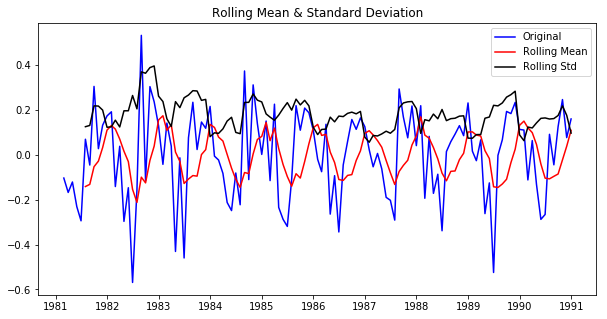

In [24]:
timeSeries.rolling_means(timeshift_transformed_data,6)

In [25]:
timeSeries.adf_test(timeshift_transformed_data.dropna())

Results of Dickey Fuller Test:
Test Statistic                  -4.284717
p-value                          0.000472
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


The plot shows that <b>Rolling Avg</b> and <b>Rolling Std Deviation</b> are <b>not flat</b>. But the <b>ADF Test</b> shows <b>low Test Statistic value(-4.28) than Critical Value (-3.49(1%),-2.88(5%),-2.58(10%)</b>. 


<b>Hence the result data is of Time Shift Transformation is Stationary and can be taken for Modelling.</b>

<b> The Log Moving Average Transformation and Time Shift Transformation look suitable for Modelling but I am going with *Log Moving Average Transformation* as it passes both *Visual test (Rolling stats test) and ADF Test*</b>

<a id=PlottingACFPACF></a>
### SECTION 6:Plotting ACF & PACF

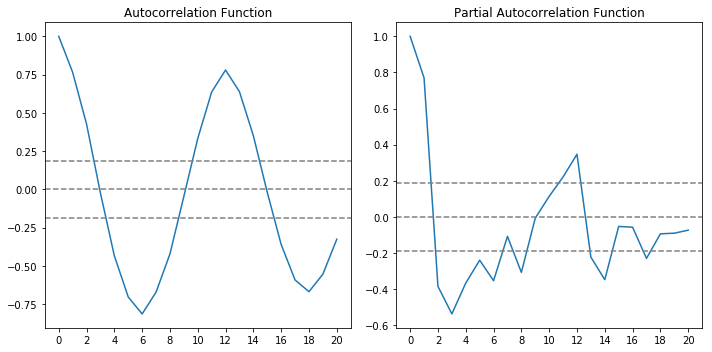

In [26]:
timeSeries.plotting_acf_pacf(log_MovingAverage_data.dropna())

From <b>ACF Graph:</b><br>
 x=3 when y=0 =><b> Q=3</b> 

From <b>PACF Graph:</b><br>
 x=2 when y=0 =><b> P=2</b>

In [27]:
log_MovingAverage_data.dropna(inplace=True)

In [28]:
log_MovingAverage_data.head()

,Temp
Date,
1981-12-31,0.233147
1982-01-31,0.430192
1982-02-28,0.297342
1982-03-31,0.326778
1982-04-30,0.036188


In [29]:
train,test=data.data_split(log_MovingAverage_data)

In [30]:
train.head()

Date
1984-05-31   -0.229613
1989-02-28    0.256443
1985-07-31   -0.523931
1990-11-30    0.101909
1987-06-30   -0.240233
Name: Temp, dtype: float64

<a id=BuildingModels></a>
### SECTION 7:Building Models
<a id=ARModel></a>
### SECTION 7.1:AR Model

In [31]:
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

C:\Users\sanga\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 12
Coefficients: const       0.000054
L1.Temp    -0.134493
L2.Temp     0.003258
L3.Temp    -0.091523
L4.Temp     0.076529
L5.Temp    -0.007220
L6.Temp    -0.159597
L7.Temp     0.017035
L8.Temp    -0.119351
L9.Temp     0.081675
L10.Temp    0.016730
L11.Temp   -0.188658
L12.Temp    0.004208
dtype: float64


In [32]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions.head()
for i in range(len(train),len(train)+len(test)-1):
    print('predicted=%f, expected=%f' % (predictions[i], test[i-len(train)]))

C:\Users\sanga\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


predicted=-0.156326, expected=-0.023425
predicted=-0.018399, expected=0.045803
predicted=0.054833, expected=0.204351
predicted=-0.045534, expected=-0.412438
predicted=0.104426, expected=0.326778
predicted=-0.149385, expected=-0.161485
predicted=0.010296, expected=-0.166713
predicted=0.018452, expected=-0.351980
predicted=0.038627, expected=0.037928
predicted=-0.024946, expected=0.182765
predicted=-0.089562, expected=-0.062760
predicted=0.075997, expected=0.204237
predicted=-0.021993, expected=0.280424
predicted=0.021673, expected=0.036188
predicted=-0.025274, expected=0.309532
predicted=-0.007115, expected=-0.100611
predicted=0.036273, expected=0.446330
predicted=-0.010502, expected=0.246062
predicted=0.010810, expected=0.214462
predicted=-0.032962, expected=-0.548316
predicted=0.024916, expected=-0.071939


In [33]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 0.056


<a id=ARMAModel></a>
### SECTION 7.2:ARMA Model

In [34]:
model = ARMA(train,order=(3,2))
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

C:\Users\sanga\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 3
Coefficients: const        -0.002036
ar.L1.Temp   -1.553908
ar.L2.Temp   -1.084865
ar.L3.Temp   -0.174754
ma.L1.Temp    1.413077
ma.L2.Temp    0.976137
dtype: float64


In [35]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(train),len(train)+len(test)-1):
    print('predicted=%f, expected=%f' % (predictions[i], test[i-len(train)]))

C:\Users\sanga\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


predicted=-0.117671, expected=-0.023425
predicted=0.001164, expected=0.045803
predicted=0.057497, expected=0.204351
predicted=-0.077809, expected=-0.412438
predicted=0.050564, expected=0.326778
predicted=-0.011971, expected=-0.161485
predicted=-0.030420, expected=-0.166713
predicted=0.043656, expected=-0.351980
predicted=-0.040508, expected=0.037928
predicted=0.013137, expected=0.182765
predicted=0.008139, expected=-0.062760
predicted=-0.027584, expected=0.204237
predicted=0.023974, expected=0.280424
predicted=-0.016515, expected=0.036188
predicted=-0.003290, expected=0.309532
predicted=0.011075, expected=-0.100611
predicted=-0.018518, expected=0.446330
predicted=0.009571, expected=0.246062
predicted=-0.004483, expected=0.214462
predicted=-0.007946, expected=-0.548316
predicted=0.007773, expected=-0.071939


In [36]:
error = mean_squared_error(test, predictions)
error

0.05965804241316824

<a id=ARIMAModel></a>
### SECTION 7.3:ARIMA Model

In [37]:
model = ARIMA(log_MovingAverage_data,order=(3,0,2))
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 3
Coefficients: const        -0.002036
ar.L1.Temp   -1.553908
ar.L2.Temp   -1.084865
ar.L3.Temp   -0.174754
ma.L1.Temp    1.413077
ma.L2.Temp    0.976137
dtype: float64


In [38]:
results_ARIMA = model.fit()

In [39]:
results_ARIMA.fittedvalues.head()

Date
1981-12-31    0.004495
1982-01-31    0.178050
1982-02-28    0.360268
1982-03-31    0.210977
1982-04-30    0.114043
Freq: M, dtype: float64

In [40]:
error = mean_squared_error(log_MovingAverage_data, results_ARIMA.fittedvalues)
print('Test MSE: %.3f' % error)

Test MSE: 0.015


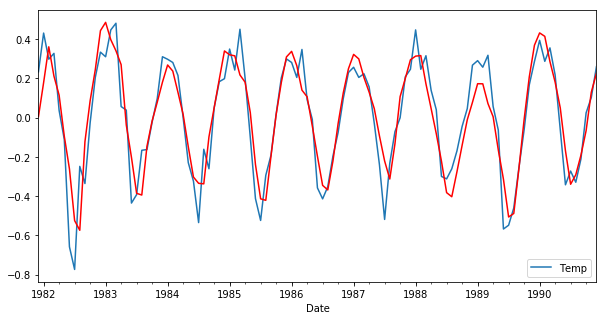

In [41]:
log_MovingAverage_data.plot()
results_ARIMA.fittedvalues.plot(color='red')

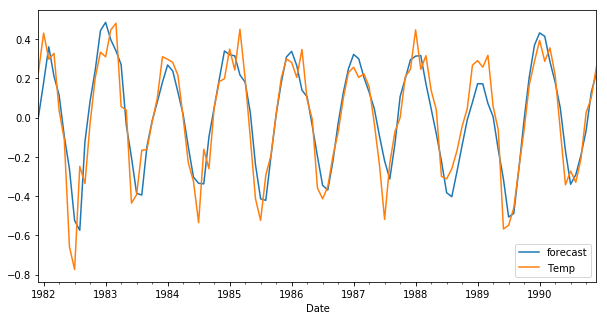

In [42]:
fitted_values = results_ARIMA.plot_predict()

In [43]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1981-12-31    0.004495
1982-01-31    0.178050
1982-02-28    0.360268
1982-03-31    0.210977
1982-04-30    0.114043
Freq: M, dtype: float64

In [44]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1981-12-31    0.004495
1982-01-31    0.182544
1982-02-28    0.542812
1982-03-31    0.753789
1982-04-30    0.867832
Freq: M, dtype: float64

In [45]:
predictions_ARIMA_log = pd.Series(log_transformed_data['Temp'], index=log_MovingAverage_data.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1981-12-31    6.054464
1982-01-31    6.423989
1982-02-28    6.642682
1982-03-31    6.891516
1982-04-30    6.708764
Freq: M, dtype: float64

In [46]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction

,0
Date,
1981-12-31,426.010420
1982-01-31,616.457274
1982-02-28,767.149993
1982-03-31,983.892020
1982-04-30,819.557049
1982-05-31,643.489521
1982-06-30,280.404147
1982-07-31,141.943076
1982-08-31,136.104789


In [47]:
data1=Data()
data1.load_data("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", ",")
data1.set_time_freq('1M')

,Temp
Date,
1981-01-31,549.1
1981-02-28,495.0
1981-03-31,418.5
1981-04-30,370.7
1981-05-31,294.2
1981-06-30,219.2
1981-07-31,234.9
1981-08-31,224.4
1981-09-30,304.3


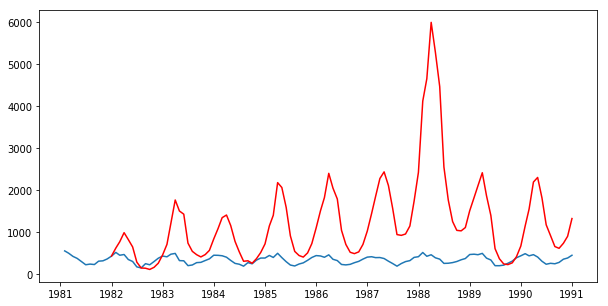

In [48]:

plt.plot(data1.set_time_freq('1M'))
plt.plot(reverted_back_prediction, color='red')
plt.show()

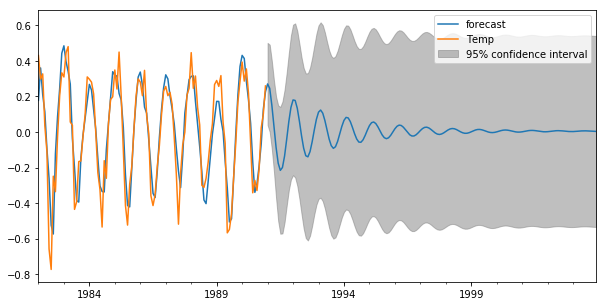

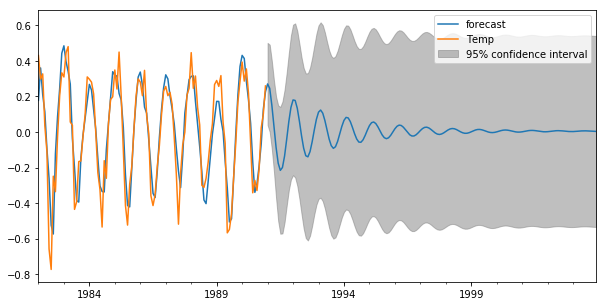

In [49]:
results_ARIMA.plot_predict(1,264)

<a id=Predictionfor10></a>
### SECTION 8:Prediction for next 10 years

In [50]:
ten_yr_forecast = results_ARIMA.predict(start=len(log_MovingAverage_data),end = len(log_MovingAverage_data) + 120 ) 

In [51]:
predictions_ARIMA_diff = pd.Series(ten_yr_forecast, copy=True)
predictions_ARIMA_diff.head()

1991-01-31    0.270270
1991-02-28    0.245579
1991-03-31    0.151376
1991-04-30    0.033235
1991-05-31   -0.086689
Freq: M, dtype: float64

In [52]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

1991-01-31    0.270270
1991-02-28    0.515849
1991-03-31    0.667224
1991-04-30    0.700459
1991-05-31    0.613770
Freq: M, dtype: float64

In [53]:
predictions_ARIMA_log = pd.Series(log_transformed_data['Temp'].iloc[-1], index=predictions_ARIMA_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

1991-01-31    6.369243
1991-02-28    6.614822
1991-03-31    6.766197
1991-04-30    6.799432
1991-05-31    6.712743
Freq: M, dtype: float64

In [54]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
1991-01-31,583.615729
1991-02-28,746.071563
1991-03-31,868.004615
1991-04-30,897.337180
1991-05-31,822.824634


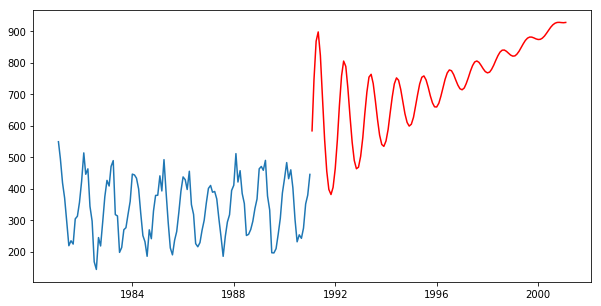

In [55]:
plt.plot(data1.set_time_freq('1M'))
plt.plot(reverted_back_prediction, color='red')
plt.show()

<b>CONCLUSIONS</b>

* Increasing trend in temperature from 1991 to 2000 year
* Annual cummulative temperature will be touching 900 deg C in 2000